In [1]:
!pip install --upgrade --quiet transformers datasets evaluate soundfile librosa  


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 84.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 8.4 MB/s eta 0:00:00


Parameter-Efficient Fine Tuning (PEFT) methods freeze the pretrained model parameters during fine-tuning and add a small number of trainable parameters (the adapters) on top of it. The adapters are trained to learn task-specific information. This approach has been shown to be very memory-efficient with lower compute usage while producing results comparable to a fully fine-tuned model.

Adapters trained with PEFT are also usually an order of magnitude smaller than the full model, making it convenient to share, store, and load them.

In [2]:
!pip install --upgrade --quiet peft


# Supported PEFT models
🤗 Transformers natively supports some PEFT methods, meaning you can load adapter weights stored locally or on the Hub and easily run or train them with a few lines of code. The following methods are supported:

Low Rank Adapters

IA3

AdaLoRA

If you want to use other PEFT methods, such as prompt learning or prompt tuning, or learn about the 🤗 PEFT library in general, please refer to the documentation.

https://huggingface.co/docs/peft/index

# Load a PEFT adapter

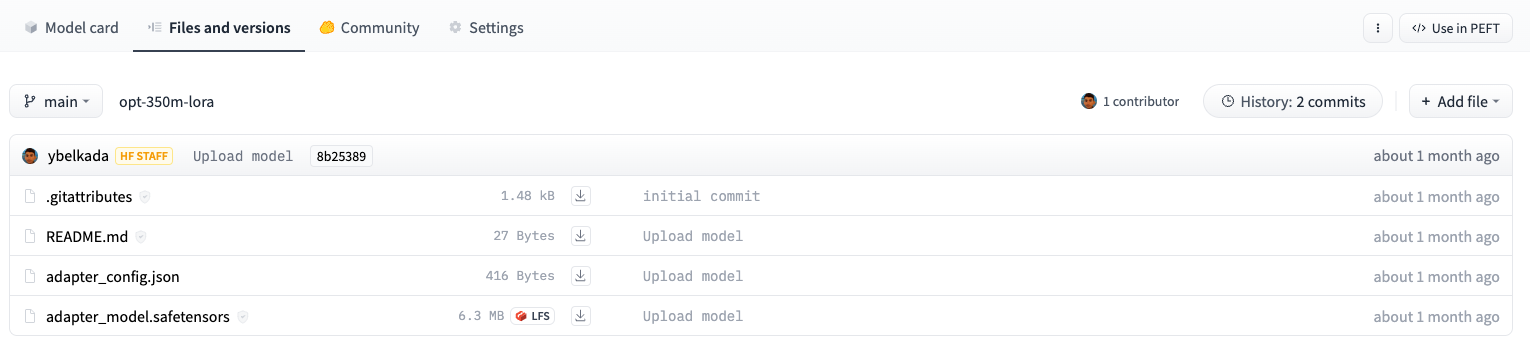


To load and use a PEFT adapter model from 🤗 Transformers, make sure the Hub repository or local directory contains an adapter_config.json file and the adapter weights, as shown in the example image above. Then you can load the PEFT adapter model using the AutoModelFor class. For example, to load a PEFT adapter model for causal language modeling:

specify the PEFT model id

pass it to the AutoModelForCausalLM class
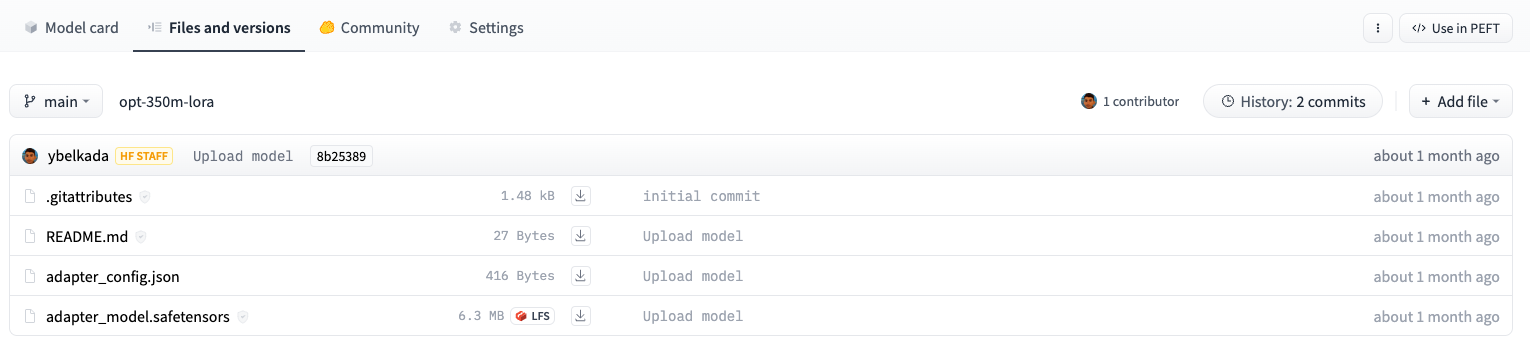

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = "ybelkada/opt-350m-lora"
model = AutoModelForCausalLM.from_pretrained(peft_model_id)

adapter_config.json:   0%|          | 0.00/416 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/662M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/6.30M [00:00<?, ?B/s]

In [4]:
#You can also load a PEFT adapter by calling the load_adapter method:

from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "facebook/opt-350m"
peft_model_id = "ybelkada/opt-350m-lora"

model = AutoModelForCausalLM.from_pretrained(model_id)
model.load_adapter(peft_model_id)

In [23]:
!pip install -qU bitsandbytes

In [24]:
%reset -f

# Load in 8bit or 4bit
The bitsandbytes integration supports 8bit and 4bit precision data types, which are useful for loading large models because it saves memory (see the bitsandbytes integration guide to learn more). Add the load_in_8bit or load_in_4bit parameters to from_pretrained() and set device_map="auto" to effectively distribute the model to your hardware:

In [26]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import bitsandbytes


peft_model_id = "ybelkada/opt-350m-lora"
model = AutoModelForCausalLM.from_pretrained(peft_model_id, ) #quantization_config=BitsAndBytesConfig(load_in_8bit=True)

In [27]:
!pip install peft -qU

In [28]:
%reset -f

# Add a new adapter
You can use ~peft.PeftModel.add_adapter to add a new adapter to a model with an existing adapter as long as the new adapter is the same type as the current one. For example, if you have an existing LoRA adapter attached to a model:

In [38]:
from transformers import AutoModelForCausalLM, OPTForCausalLM, AutoTokenizer
from peft import LoraConfig

model_id = "facebook/opt-350m"
model = AutoModelForCausalLM.from_pretrained(model_id)

lora_config = LoraConfig(
    target_modules=["q_proj", "k_proj"],
    init_lora_weights=False
)

model.add_adapter(lora_config, adapter_name="adapter_1")

In [39]:
# attach new adapter with same config
model.add_adapter(lora_config, adapter_name="adapter_2")

In [40]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
text = "Hello"
inputs = tokenizer(text, return_tensors="pt")

Now you can use ~peft.PeftModel.set_adapter to set which adapter to use:



In [41]:
# use adapter_1
model.set_adapter("adapter_1")
output_disabled = model.generate(**inputs)
print(tokenizer.decode(output_disabled[0], skip_special_tokens=True))

# use adapter_2
model.set_adapter("adapter_2")
output_enabled = model.generate(**inputs)
print(tokenizer.decode(output_enabled[0], skip_special_tokens=True))

Hello, I'm a newbie to the game, and I'm looking for a good place to start
Hello, I'm a new player and I'm looking for a group to play with. I'm a


In [42]:
from transformers import AutoModelForCausalLM, OPTForCausalLM, AutoTokenizer
from peft import PeftConfig

model_id = "facebook/opt-350m"
adapter_model_id = "ybelkada/opt-350m-lora"
tokenizer = AutoTokenizer.from_pretrained(model_id)
text = "Hello"
inputs = tokenizer(text, return_tensors="pt")

model = AutoModelForCausalLM.from_pretrained(model_id)
peft_config = PeftConfig.from_pretrained(adapter_model_id)

# to initiate with random weights
peft_config.init_lora_weights = False

model.add_adapter(peft_config)
model.enable_adapters()
output = model.generate(**inputs)

To disable the adapter module:


In [43]:
model.disable_adapters()
output = model.generate(**inputs)

# Train a PEFT adapter
PEFT adapters are supported by the Trainer class so that you can train an adapter for your specific use case. It only requires adding a few more lines of code. For example, to train a LoRA adapter:

Define your adapter configuration with the task type and hyperparameters (see ~peft.LoraConfig for more details about what the hyperparameters do).

In [44]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

In [46]:
# Add adapter to the model.

model.add_adapter(peft_config, adapter_name="new_model")

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model,)
trainer.train()

In [52]:
model.save_pretrained("./")
model = AutoModelForCausalLM.from_pretrained("./")

# Add additional trainable layers to a PEFT adapter
You can also fine-tune additional trainable adapters on top of a model that has adapters attached by passing modules_to_save in your PEFT config. For example, if you want to also fine-tune the lm_head on top of a model with a LoRA adapter:

In [53]:
from transformers import AutoModelForCausalLM, OPTForCausalLM, AutoTokenizer
from peft import LoraConfig

model_id = "facebook/opt-350m"
model = AutoModelForCausalLM.from_pretrained(model_id)

lora_config = LoraConfig(
    target_modules=["q_proj", "k_proj"],
    modules_to_save=["lm_head"],
)

model.add_adapter(lora_config)